In [2]:
import pandas as pd

In [3]:
us = pd.read_csv('../covid-19-data/us.csv', parse_dates=['date'])

In [4]:
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (16,9)
plt.rcParams['figure.max_open_warning'] = 0

In [5]:
dates = us['date']
us_daily_cases = us['cases'].diff().fillna(0)
us_daily_deaths = us['deaths'].diff().fillna(0)

In [6]:
print('final date:', dates[len(dates)-1])

final date: 2021-07-15 00:00:00


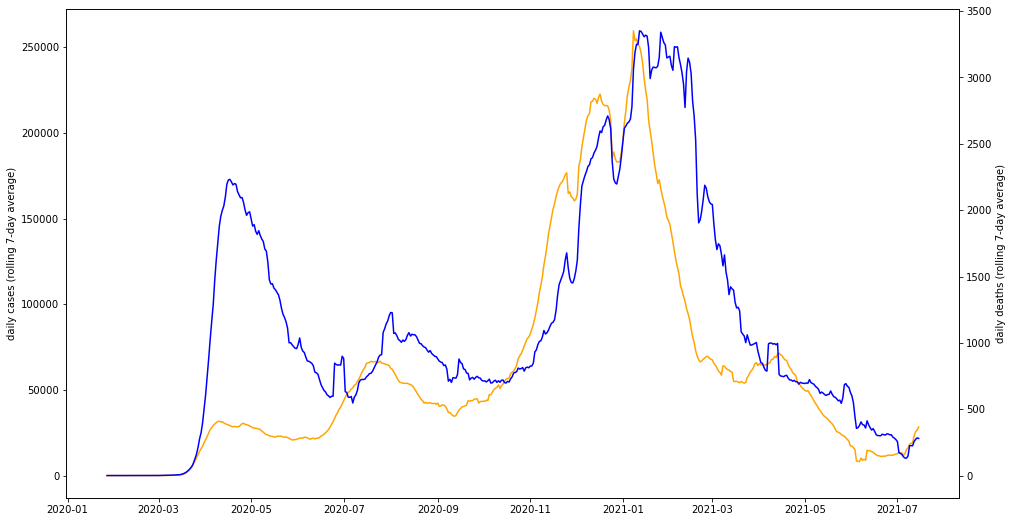

In [7]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.set_ylabel('daily cases (rolling 7-day average)')
ax2.set_ylabel('daily deaths (rolling 7-day average)')

p = ax1.plot(dates,us_daily_cases.rolling(7).mean(),color='orange')
p = ax2.plot(dates,us_daily_deaths.rolling(7).mean(), color='blue')

In [8]:
from math import pi, exp, sqrt, log
import numpy as np
from scipy.optimize import curve_fit

In [9]:
def gauss(x, mu, sigma):
    # normalized to unit integral
    norm = 1.0/(sigma * sqrt(2*pi))
    arg = -0.5 * ((x - mu)/sigma)**2
    return norm * exp(arg)

In [10]:
def normfn(i, norm1, norm1_end, norm2, norm2_end, norm3, norm3_end, norm4):
    if i < norm1_end:
#        return (norm2 - norm1)/norm1_end * i + norm1
        return norm1
    elif i < norm2_end:
        return (norm3 - norm2)/(norm2_end - norm1_end) * (i - norm1_end) + norm2
    elif i < norm3_end:
        return (norm4 - norm3)/(norm3_end - norm2_end) * (i - norm2_end) + norm3
    else:
        return norm4

In [10]:
# plt.plot([normfn(i, 10, 50, 4, 100, 2, 150, 1) for i in range(0, 300)])

In [11]:
def full_model(newcases, norm1, norm1_end, norm2, norm2_end, norm3, norm3_end, norm4, offset, width):
    num = len(newcases)
    retval = np.zeros(num, np.float64)
    for i in range(0, num):
        for j in range(1, i):
            retval[i] += newcases[j] * normfn(j, norm1, norm1_end, norm2, norm2_end, norm3, norm3_end, norm4) * gauss(i-j, offset, width)
    return retval

In [12]:
norm1_end = 75
norm2_end = 150
norm3_end = 200
sigma = 18
def model1(newcases, norm1, norm2, norm3, norm4, offset):
    global norm1_end, norm2_end, norm3_end, sigma
    return full_model(newcases, norm1, norm1_end, norm2, norm2_end, norm3, norm3_end, norm4, offset, sigma)

In [16]:
def us_fit(dates, daily_cases, daily_deaths, plot=True):
    sigma = np.ones(len(daily_cases))
    sigma[0:150] = 10
    popt, pcov = curve_fit(model1, daily_cases, daily_deaths, [10, 0.1, 0.1, 0.002, 18], sigma)
    if plot:
        fig, ax = plt.subplots()
        ax.plot(dates, daily_deaths.rolling(7).mean(), color='blue', label='observed deaths')
        ax.plot(dates, model1(daily_cases, *popt), color='red', label='model deaths')
        ax.axvspan(dates[0], dates[149], alpha=0.2)
    return popt, pcov

In [14]:
len(us_daily_cases)

542

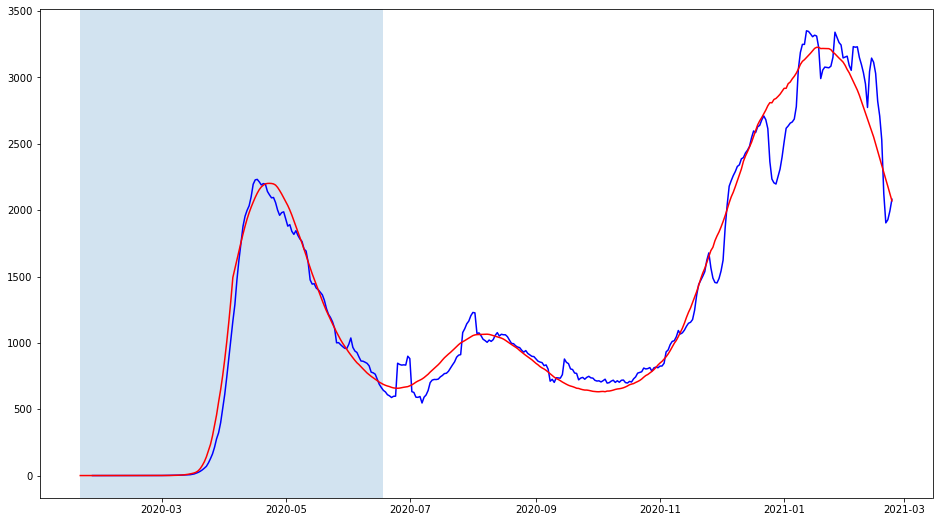

In [18]:
fitend = 400
popt, pcov = us_fit(dates[:fitend], us_daily_cases[:fitend], us_daily_deaths[:fitend])

In [19]:
popt

array([2.71121969e-01, 5.10859662e-02, 2.77862502e-02, 1.79883511e-02,
       1.83456937e+01])

In [16]:
perr = np.sqrt(np.diag(pcov))
perr

array([1.45250746e-01, 2.91548278e-02, 3.57688862e-03, 6.09608420e-04,
       1.86480116e+00])

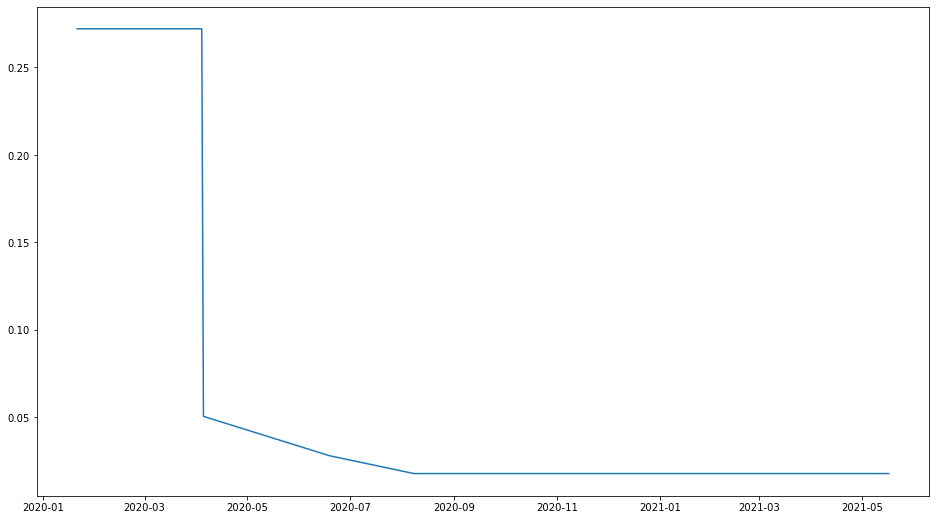

In [17]:
plt.plot(dates, 
    [normfn(i, popt[0], norm1_end, popt[1], norm2_end, popt[2], norm3_end, popt[3]) for i in range(0, len(dates))]);

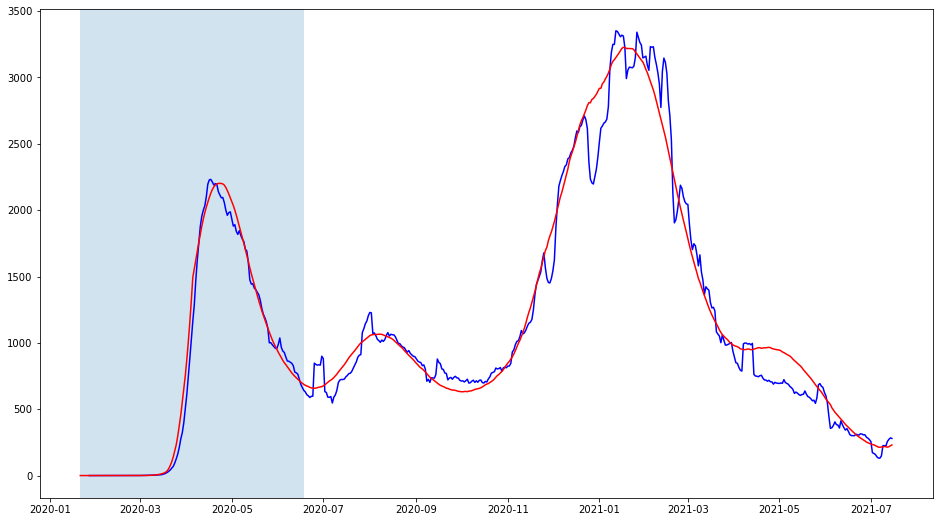

In [22]:
fig, ax = plt.subplots()
ax.plot(dates, us_daily_deaths.rolling(7).mean(), color='blue', label='observed deaths')
ax.plot(dates, model1(us_daily_cases, *popt), color='red', label='model deaths')
ax.axvspan(dates[0], dates[149], alpha=0.2)



In [23]:
indices = range(0, len(dates))
past_days = 15
start_recent = len(dates) - past_days
recent_dates = dates[start_recent:]
recent_indices = indices[start_recent:]
recent_smooth_cases = us_daily_cases.rolling(7).mean()[start_recent:]
log_recent_smooth_cases = [log(x) for x in recent_smooth_cases]

In [24]:
order = 2
coeffs, coeff_cov = np.polyfit(recent_indices, log_recent_smooth_cases, order, cov=True)
log_case_model = np.poly1d(coeffs)
last = recent_indices[-1]
future_num = 30
future_indices = range(last, last + future_num)

In [25]:
print("polynomial coeffs", coeffs)
print("polynomial coeff errs", np.sqrt(np.diag(coeff_cov)))

polynomial coeffs [ 4.41351394e-03 -4.65114533e+00  1.23484124e+03]
polynomial coeff errs [1.08945113e-03 1.16354133e+00 3.10651218e+02]


In [26]:
n = len(us_daily_cases)
N = n + future_num
future_dates = pd.date_range(dates[0], periods=N)
future_cases = np.zeros(N, np.float64)
future_cases[0:n] = us_daily_cases.rolling(7).mean().fillna(0)
future_cases[n:] =  [exp(log_case_model(i)) for i in future_indices]

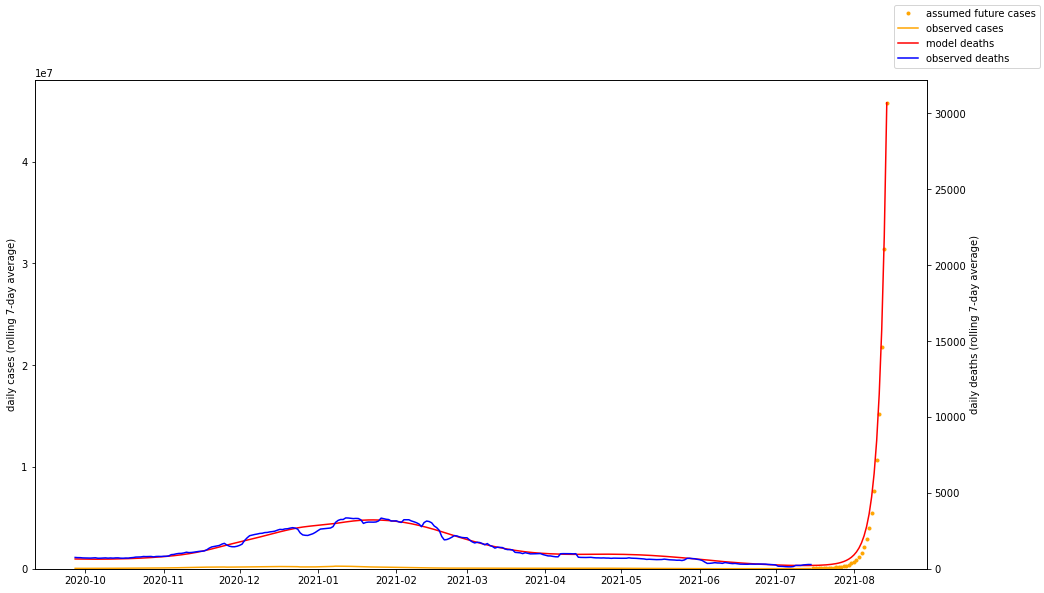

In [27]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.set_ylabel('daily cases (rolling 7-day average)')
ax2.set_ylabel('daily deaths (rolling 7-day average)')

start = 250
p = ax1.plot(future_dates[n:], future_cases[n:], '.', color='orange', label='assumed future cases')
#p = ax1.plot(dates[start:], us_daily_cases.rolling(7).mean()[start:],color='blue', label='observed cases')
p = ax1.plot(dates[start:], us_daily_cases.rolling(7).mean()[start:],color='orange', label='observed cases')
p = ax2.plot(future_dates[start:], model1(future_cases, popt[0], popt[1], popt[2], popt[3], popt[4])[start:], color='red', label='model deaths')
p = ax2.plot(dates[start:], us_daily_deaths.rolling(7).mean()[start:], color='blue', label='observed deaths')

yl1 = ax1.get_ylim()
ax1.set_ylim([0, yl1[1]])

yl2 = ax2.get_ylim()
ax2.set_ylim([0, yl2[1]])
fig.legend();

In [29]:
states = pd.read_csv('../covid-19-data/us-states.csv', parse_dates=['date'])

In [30]:
state_deaths = states.pivot(index='date', columns='state', values='deaths')
state_cases =  states.pivot(index='date', columns='state', values='cases')
all_states = states['state'].unique()
all_states.sort()

In [31]:
norm1 = popt[0]
norm2 = popt[1]
offset = popt[-1]
def model2(newcases, norm3, norm4):
    global norm1_end, norm2_end, norm3_end, sigma
    global norm1, norm2, offset
    return full_model(newcases, norm1, norm1_end, norm2, norm2_end, norm3, norm3_end, norm4, offset, sigma)

In [32]:
def state_fit(state, state_cases, state_deaths, plot=True):
    daily_cases = state_cases[state].diff().fillna(0)
    daily_deaths = state_deaths[state].diff().fillna(0)
    sigma = np.ones(len(daily_cases))
    sigma[0:150] = 10
    popt, pcov = curve_fit(model2, daily_cases, daily_deaths, [0.002, 0.002], sigma)
    if plot:
        fig, ax = plt.subplots()
        ax.plot(dates, daily_deaths.rolling(7).mean(), color='orange', label='observed deaths')
        ax.plot(dates, model2(daily_cases, *popt), color='red', label='model deaths')
        ax.axvspan(dates[0], dates[149], alpha=0.2)
        plt.title("{state} fatality rate: {percentnorm:0.2f}%"
                  .format(state=state, percentnorm=100*popt[1]))
    print("{state} fatality rate: {percentnorm:0.2f}%"
          .format(state=state, percentnorm=100*popt[1]))
    return popt

Alabama fatality rate: 2.71%
Alaska fatality rate: 0.58%
Arizona fatality rate: 2.23%
Arkansas fatality rate: 1.99%
California fatality rate: 1.74%
Colorado fatality rate: 1.34%
Connecticut fatality rate: 1.63%
Delaware fatality rate: 1.41%
District of Columbia fatality rate: 1.88%
Florida fatality rate: 1.67%
Georgia fatality rate: 1.94%
Guam fatality rate: 1.88%
Hawaii fatality rate: 1.79%
Idaho fatality rate: 1.29%
Illinois fatality rate: 1.85%
Indiana fatality rate: 1.88%
Iowa fatality rate: 1.90%
Kansas fatality rate: 2.00%
Kentucky fatality rate: 1.53%
Louisiana fatality rate: 1.91%
Maine fatality rate: 1.39%
Maryland fatality rate: 1.92%
Massachusetts fatality rate: 1.73%
Michigan fatality rate: 1.92%
Minnesota fatality rate: 1.33%
Mississippi fatality rate: 2.33%
Missouri fatality rate: 1.72%
Montana fatality rate: 1.57%
Nebraska fatality rate: 1.33%
Nevada fatality rate: 1.96%
New Hampshire fatality rate: 1.28%
New Jersey fatality rate: 1.50%
New Mexico fatality rate: 2.24%
Ne

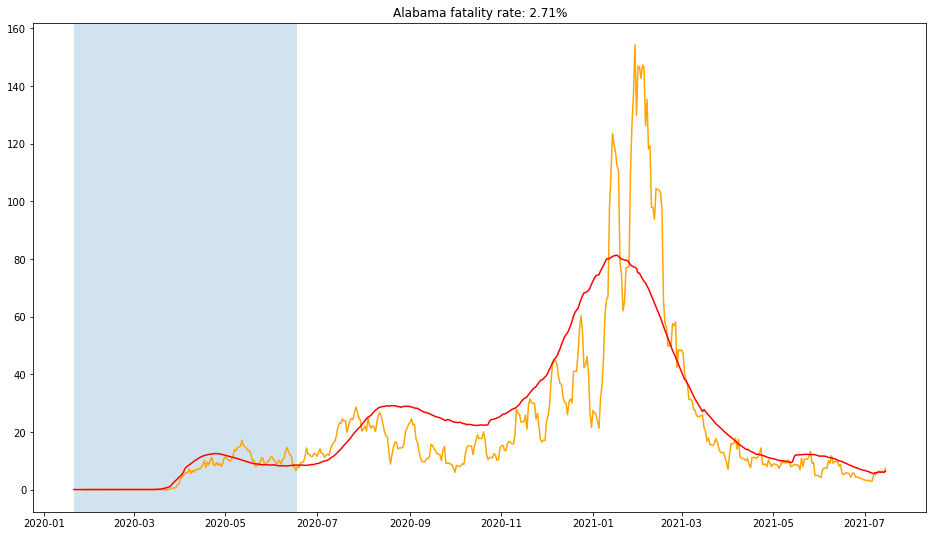

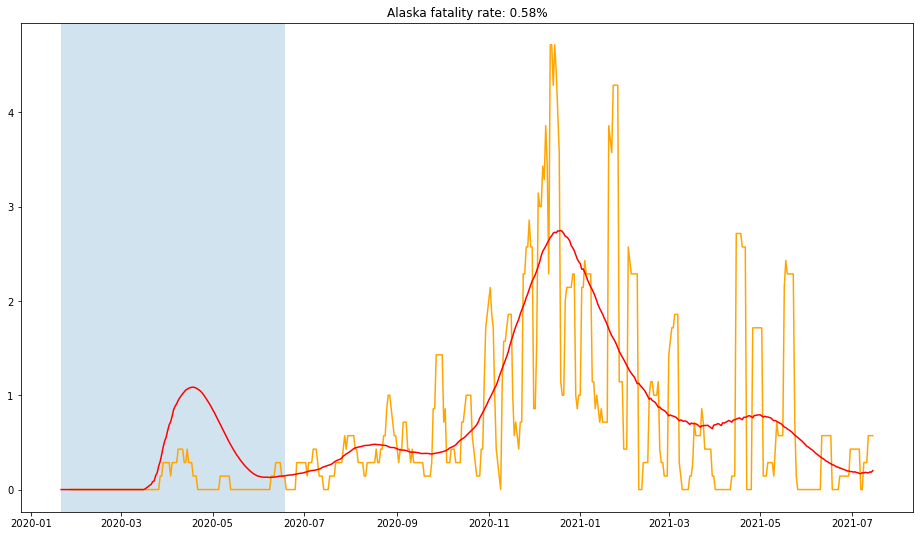

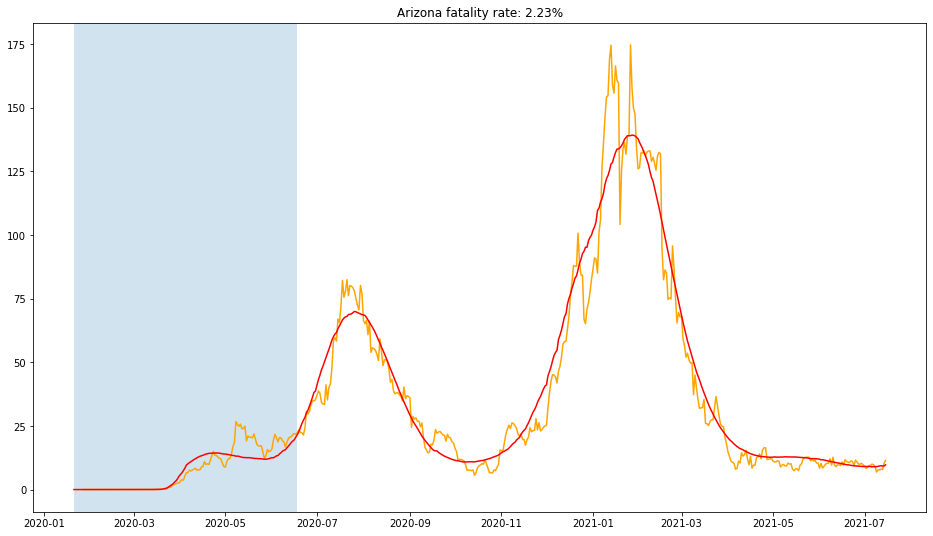

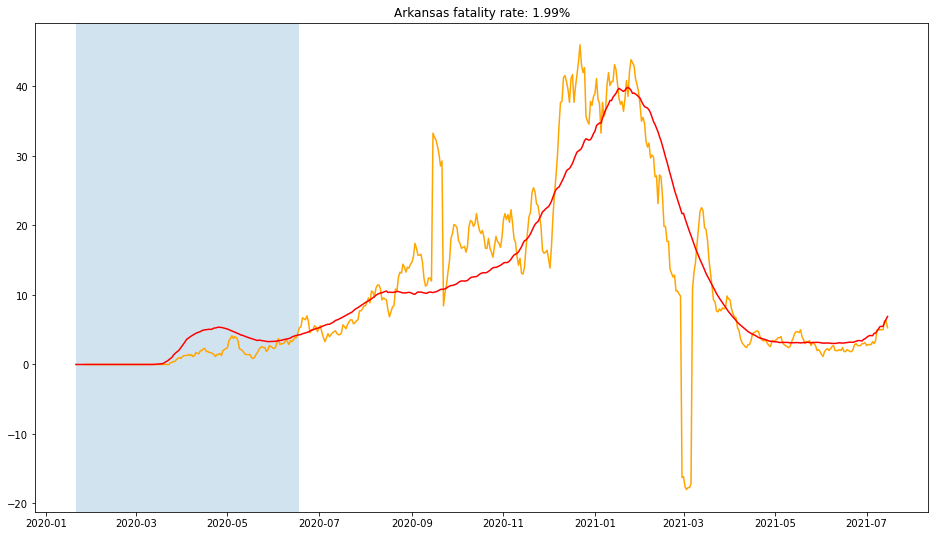

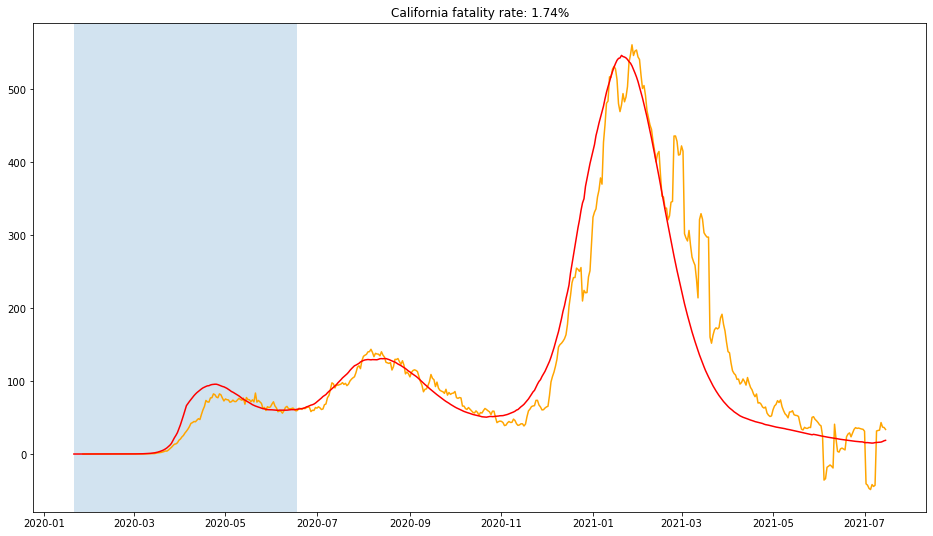

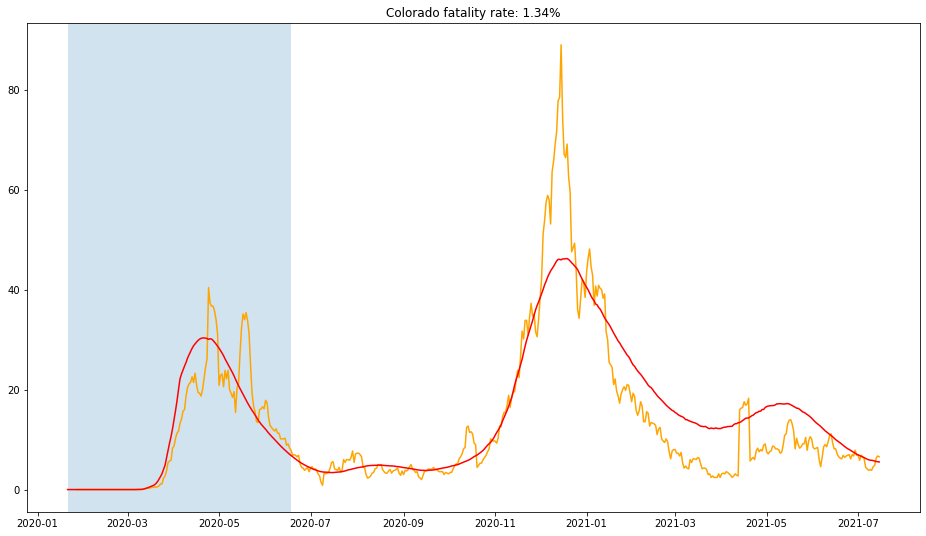

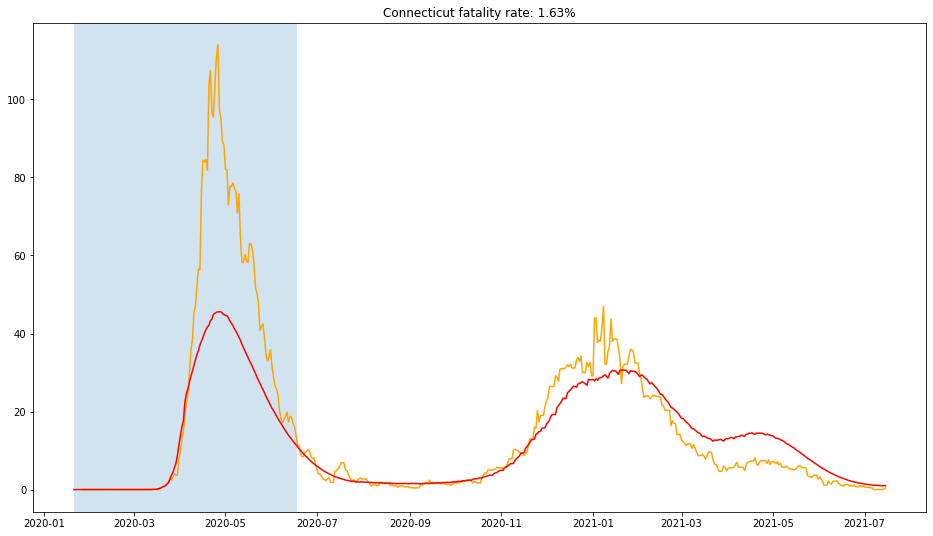

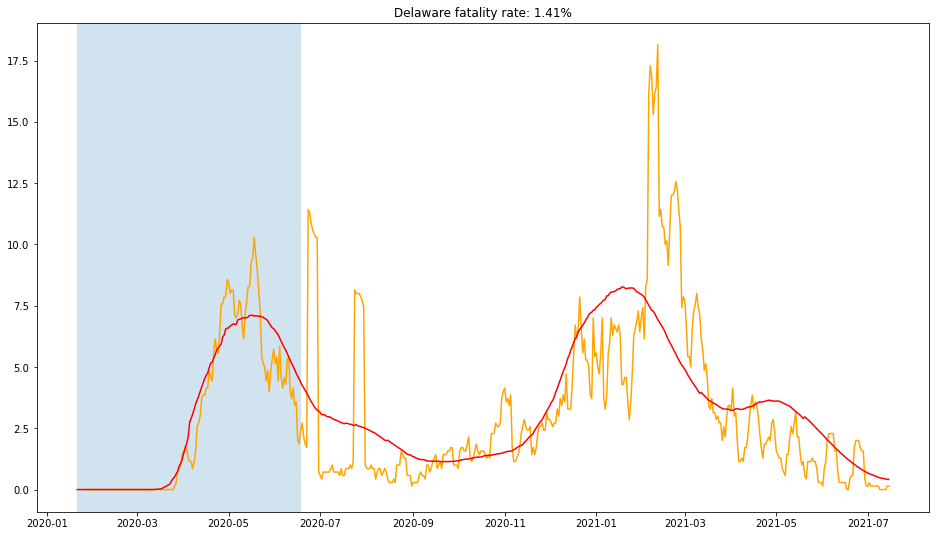

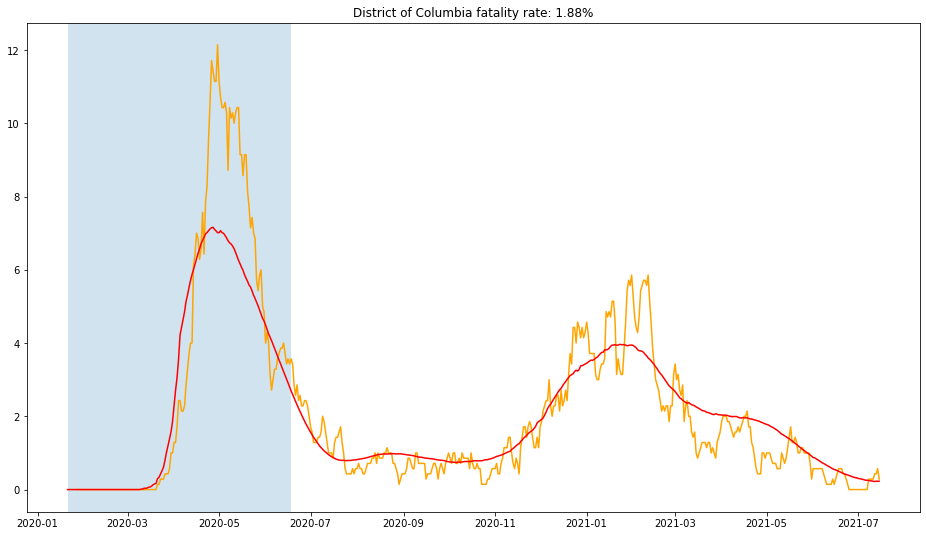

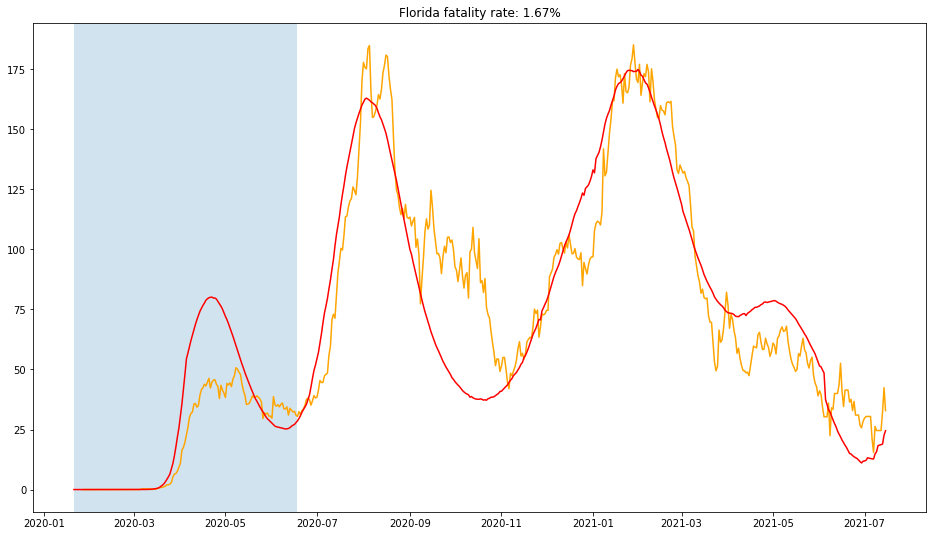

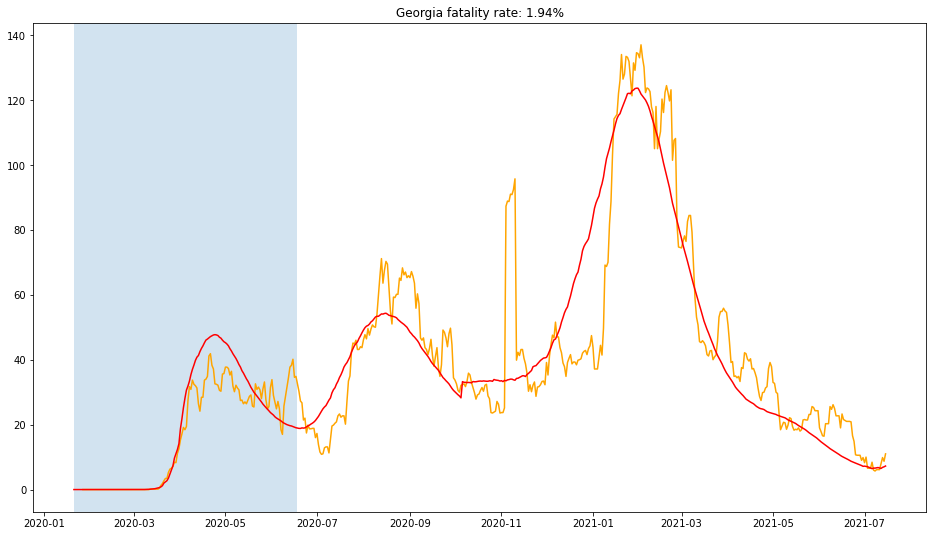

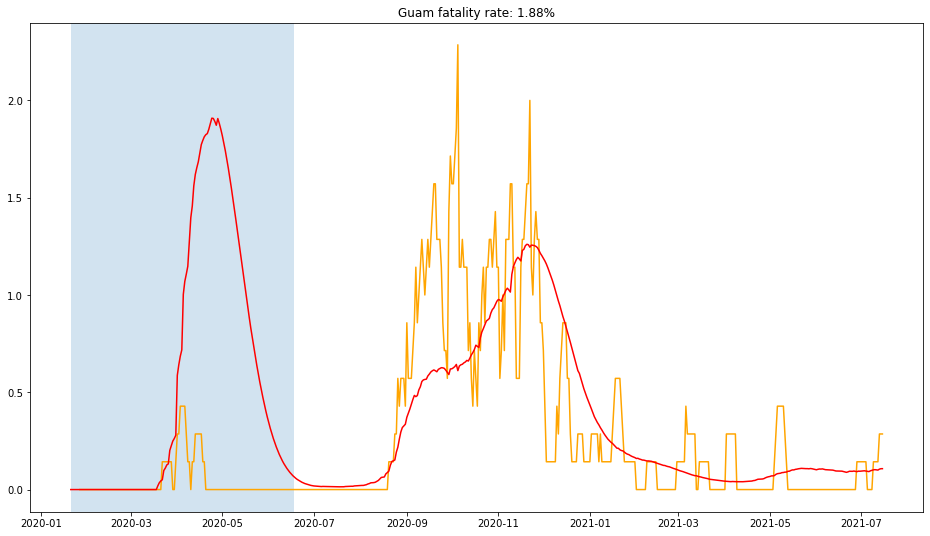

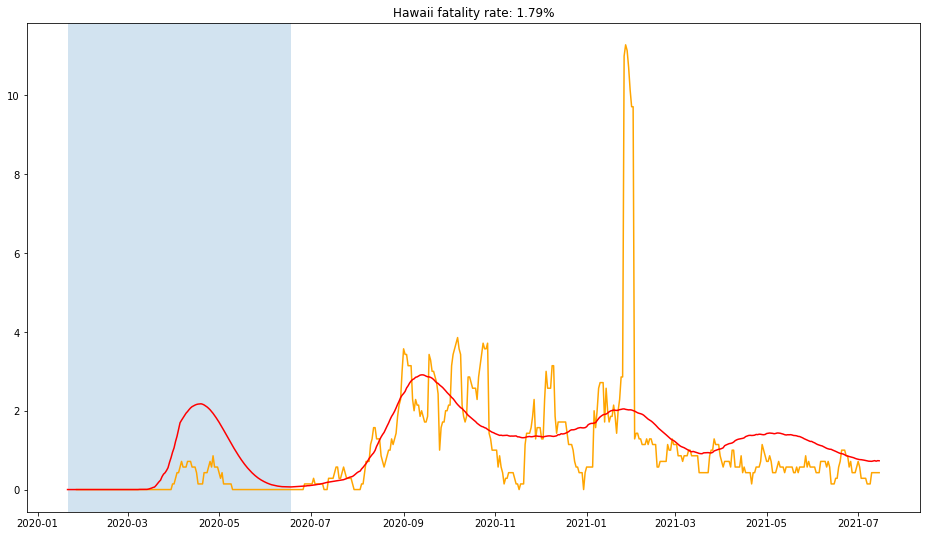

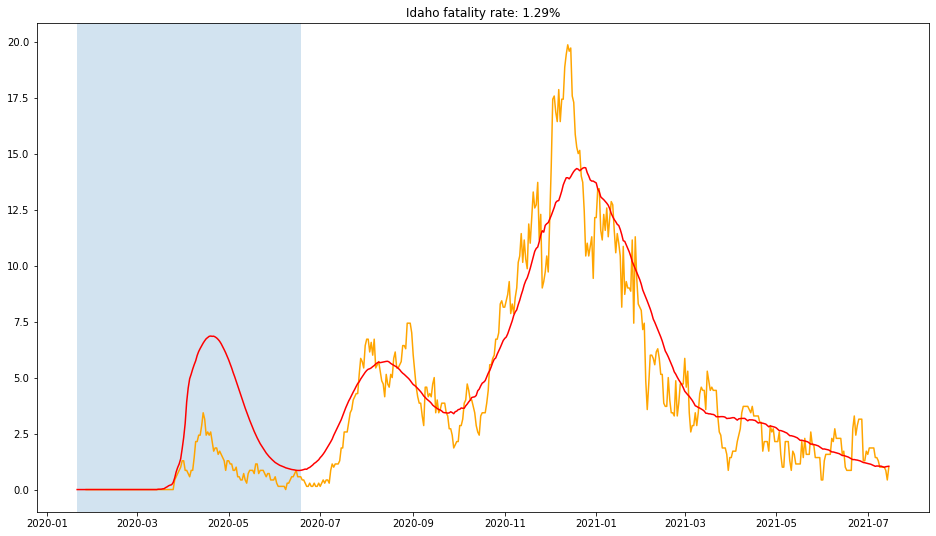

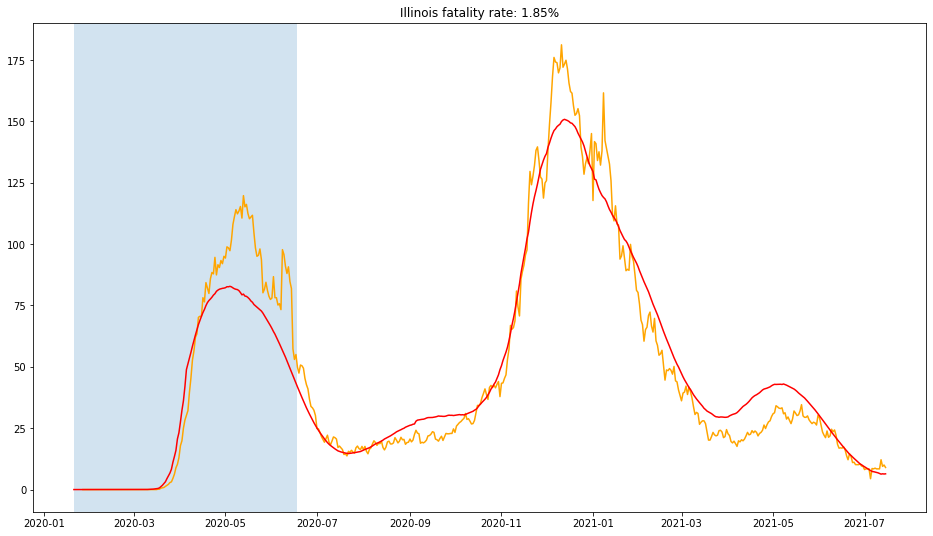

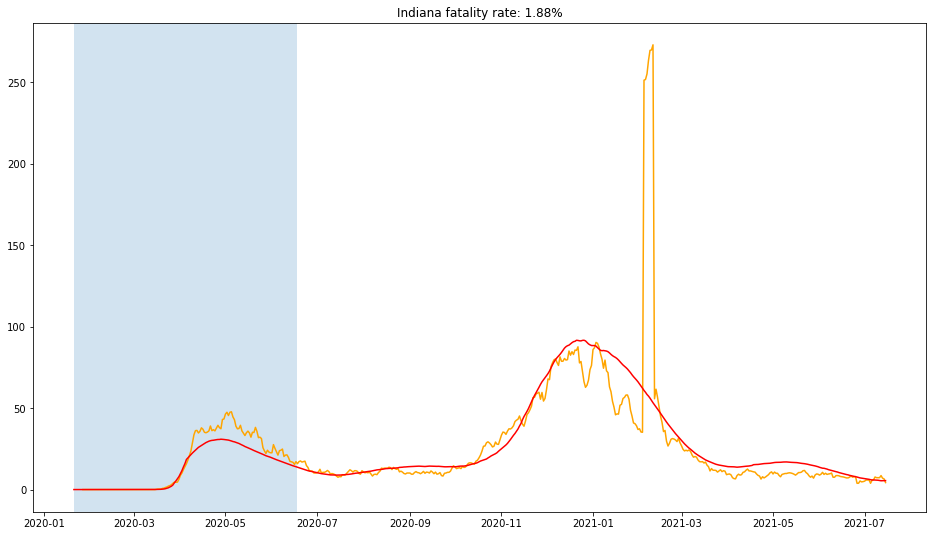

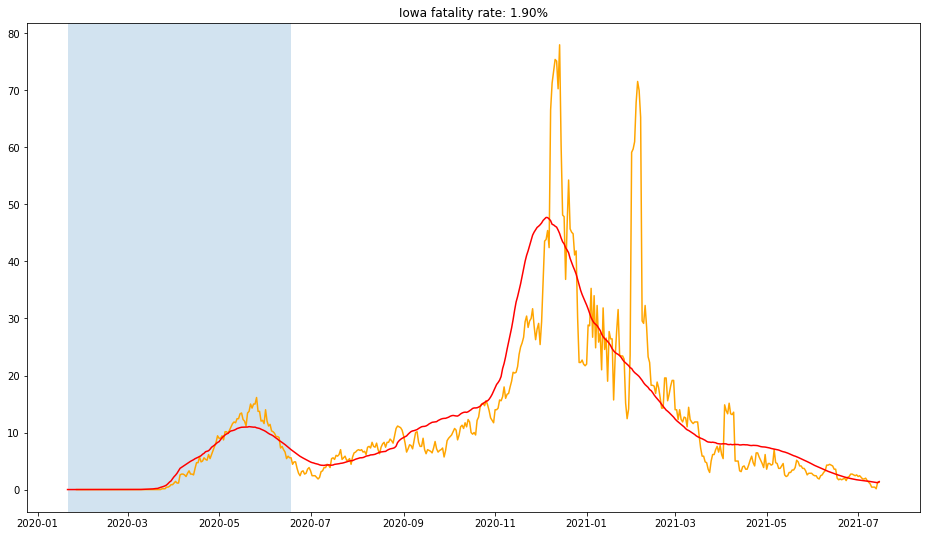

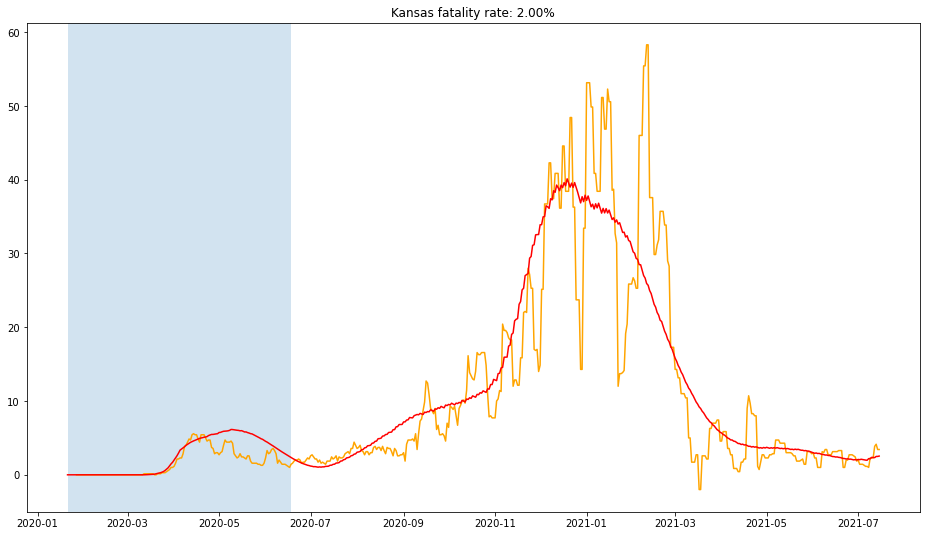

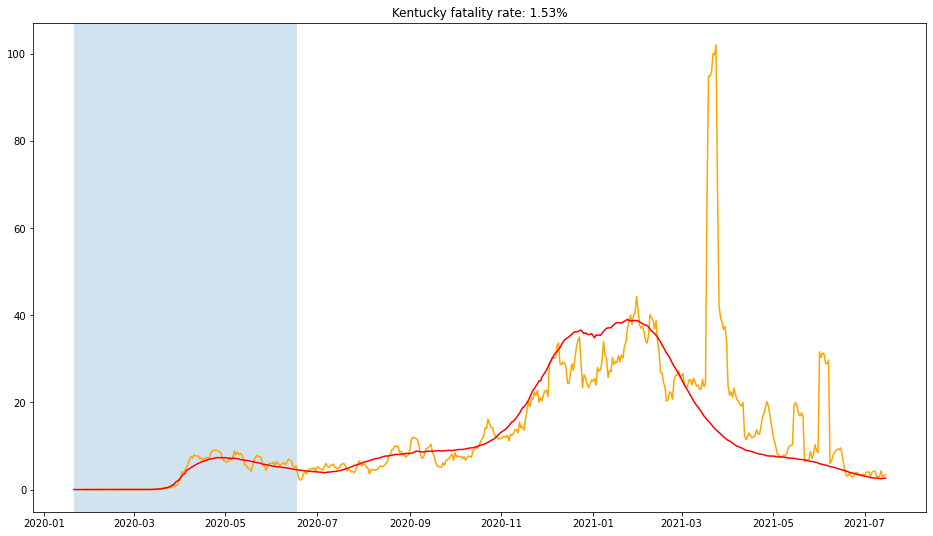

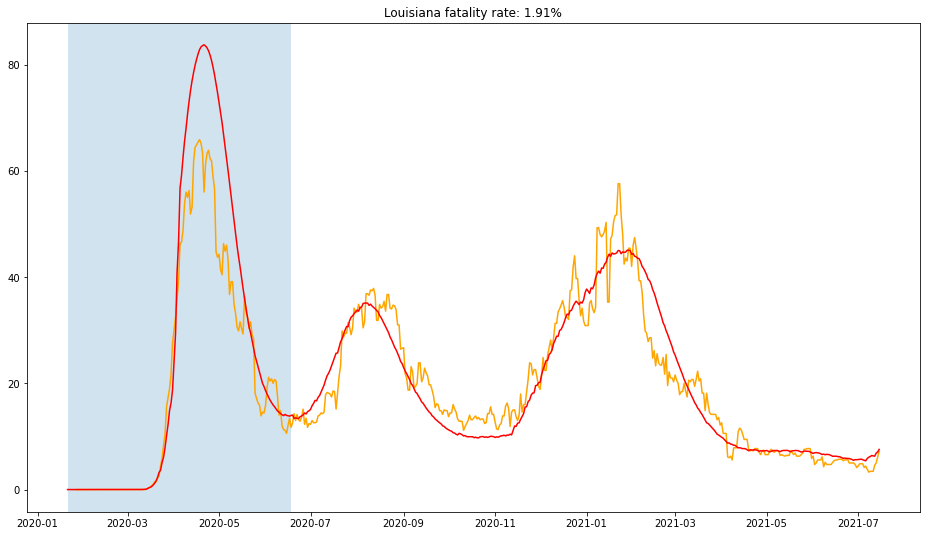

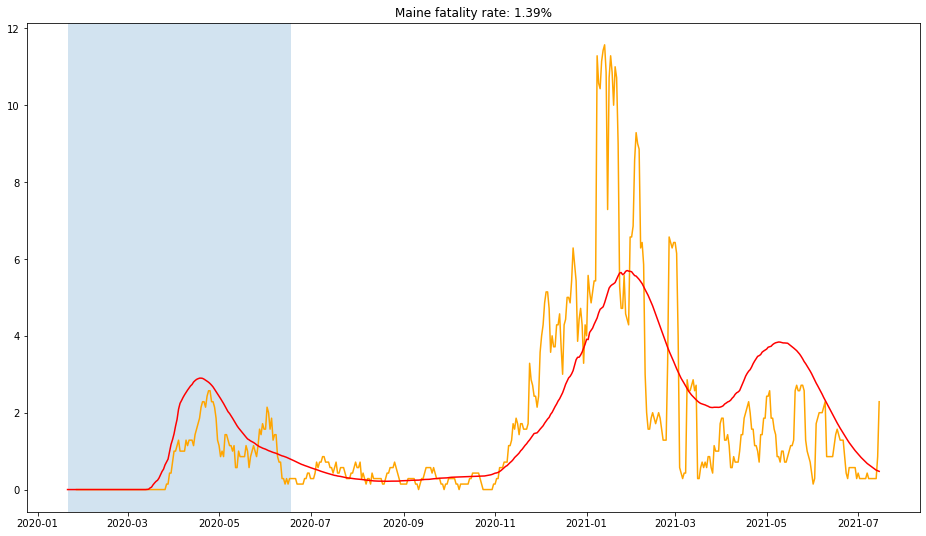

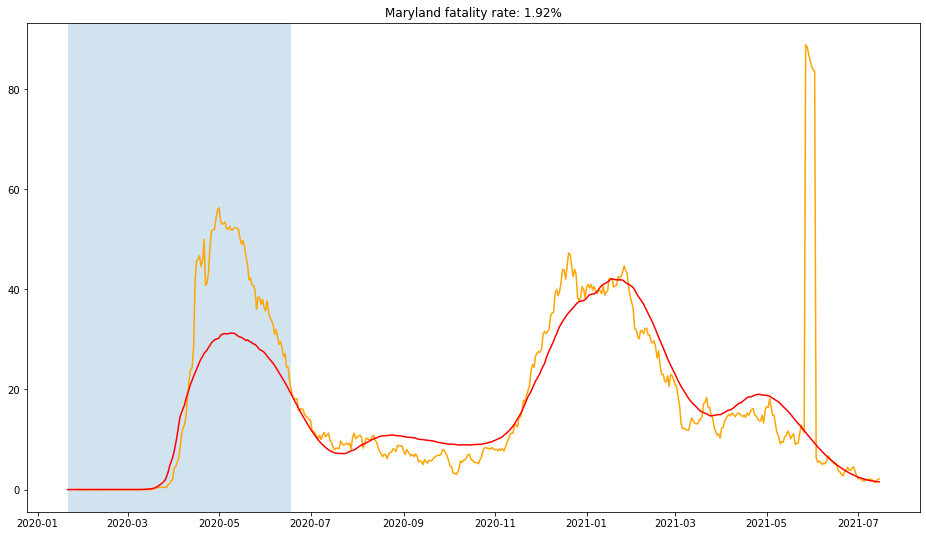

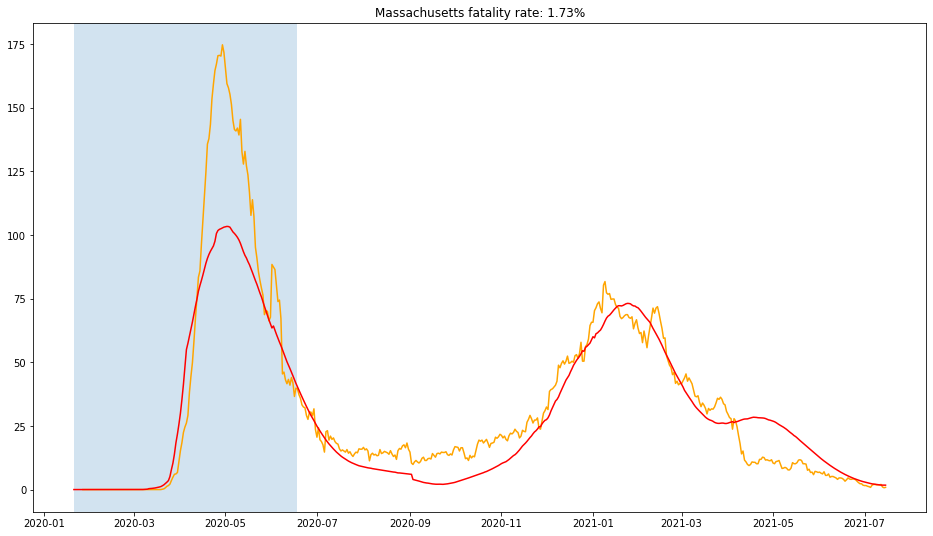

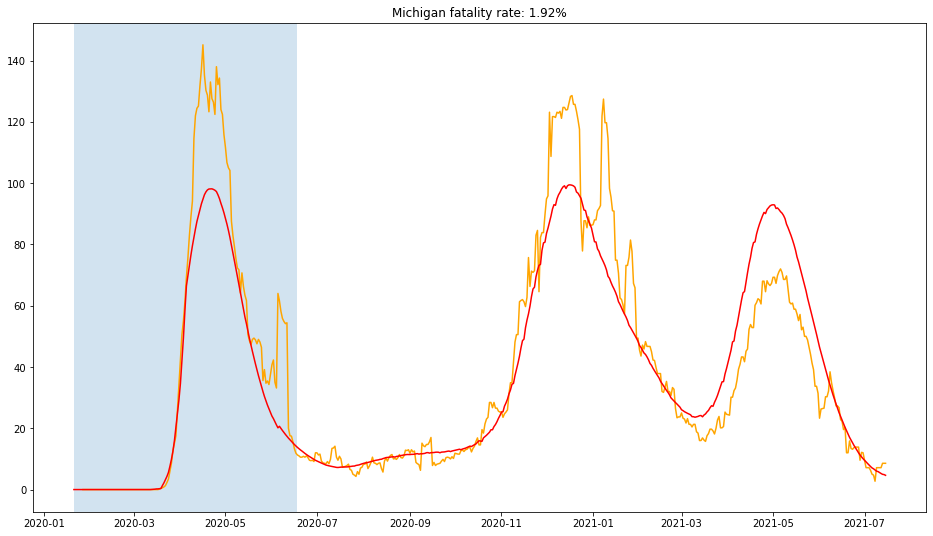

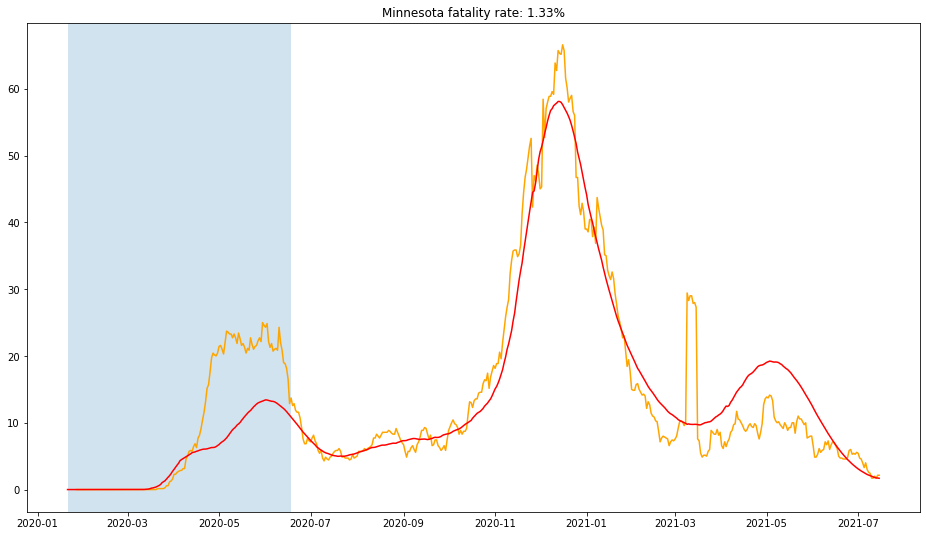

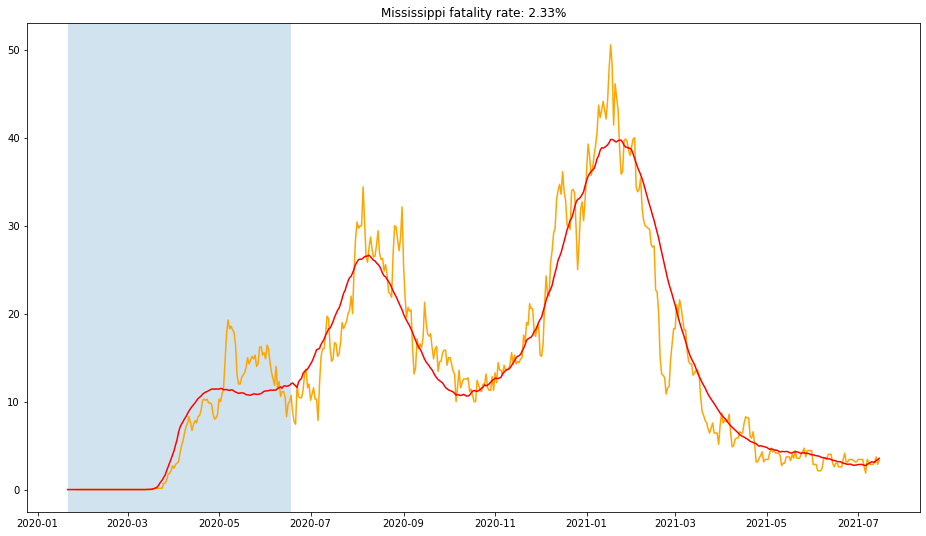

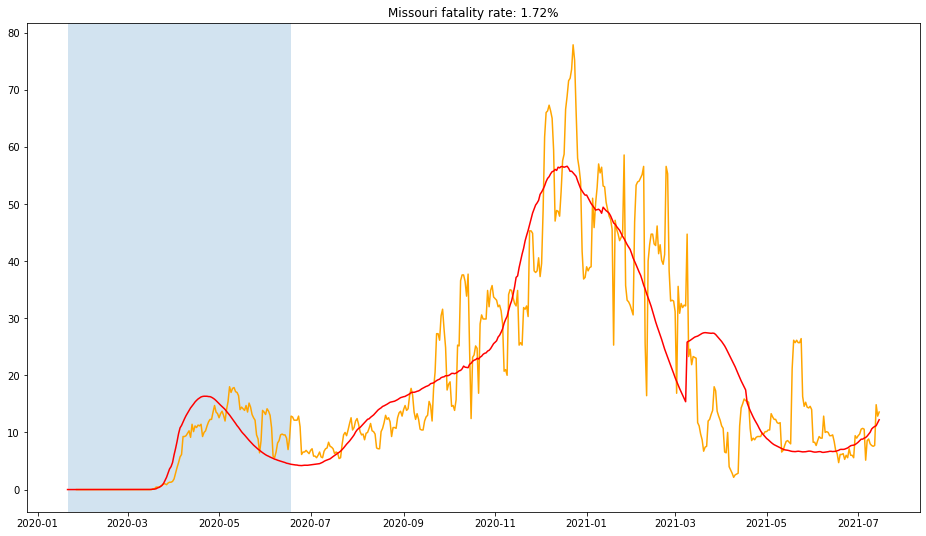

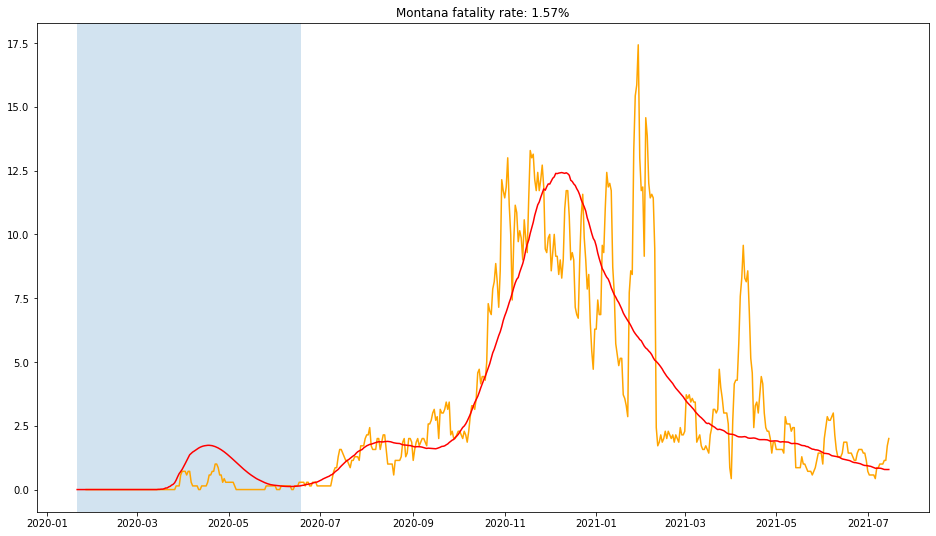

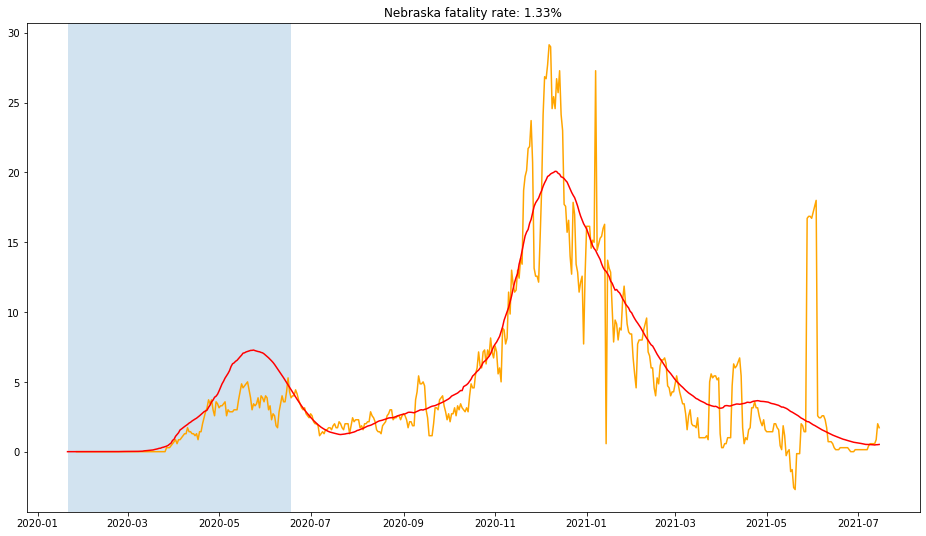

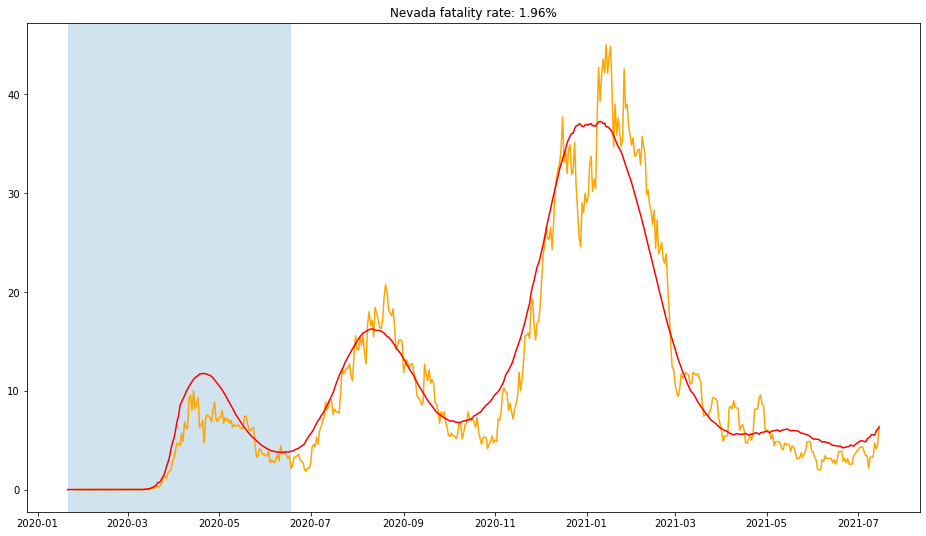

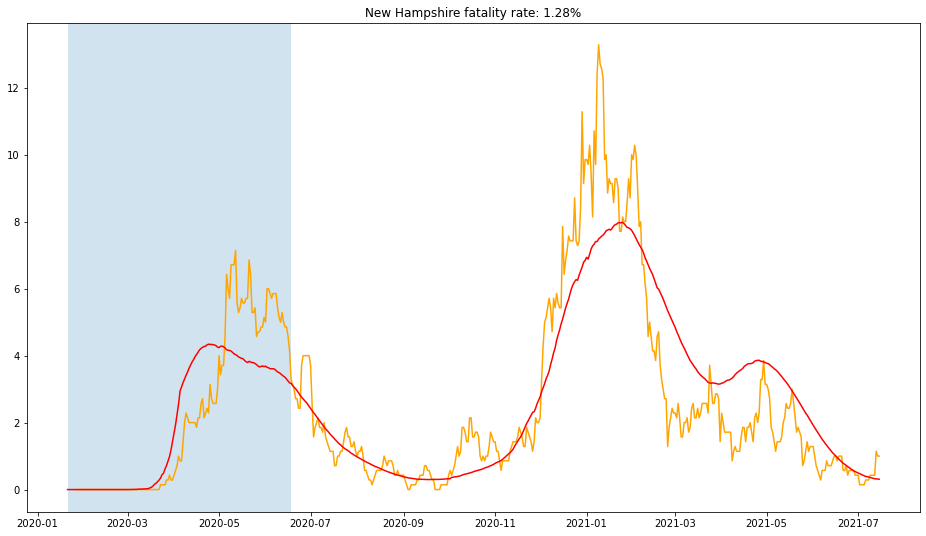

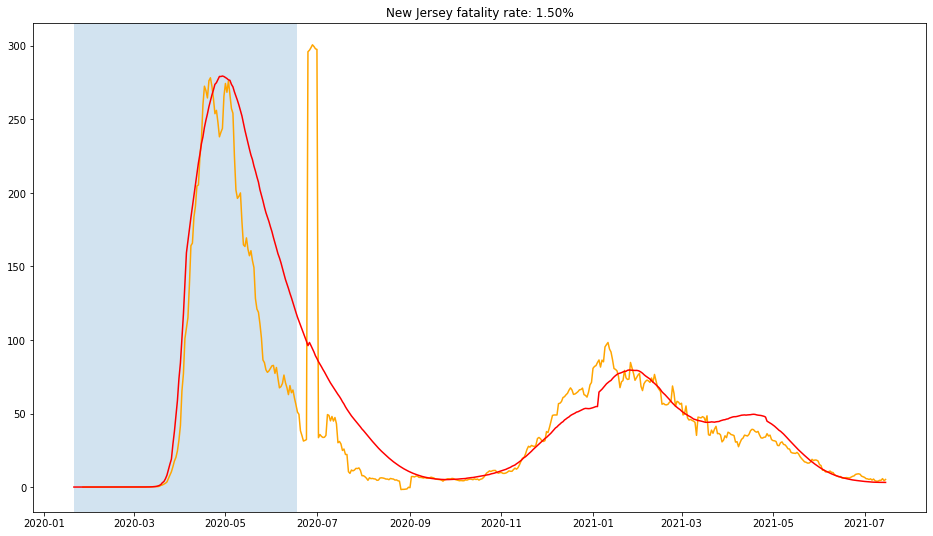

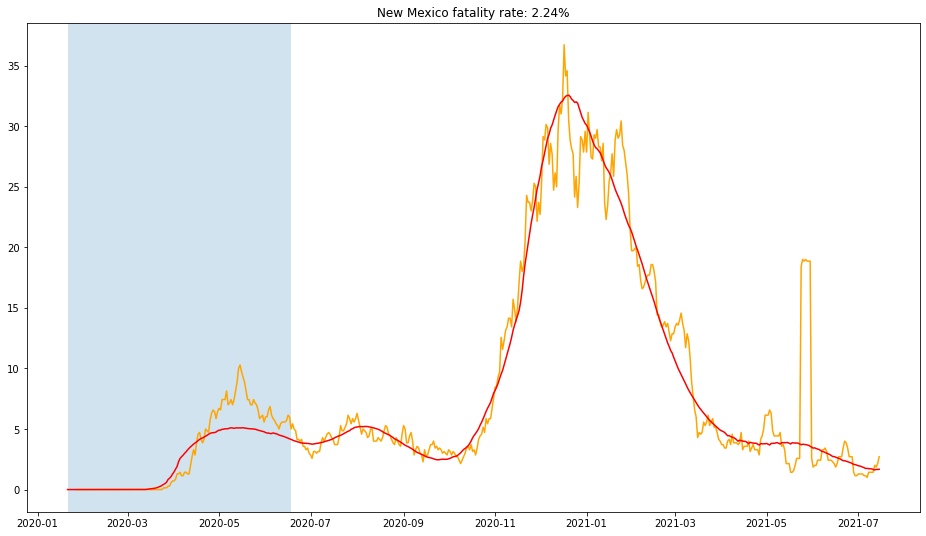

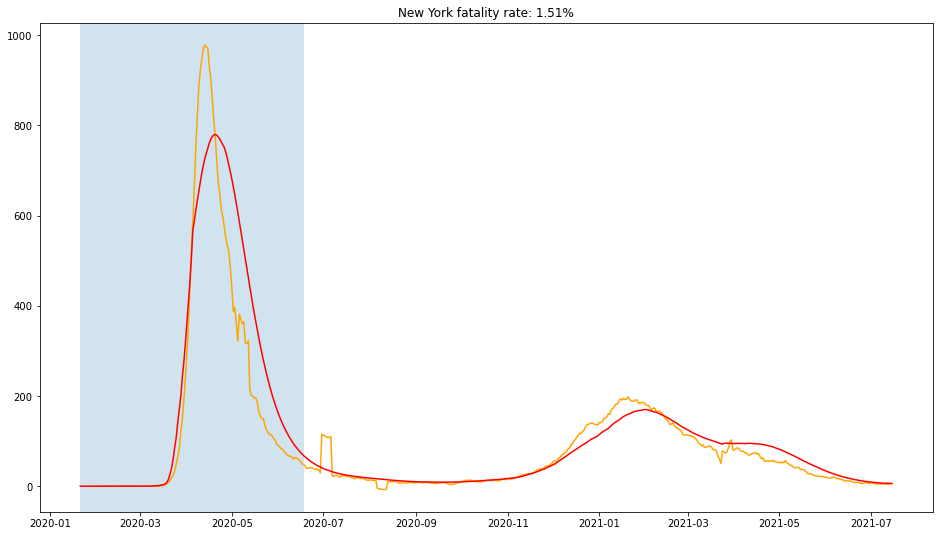

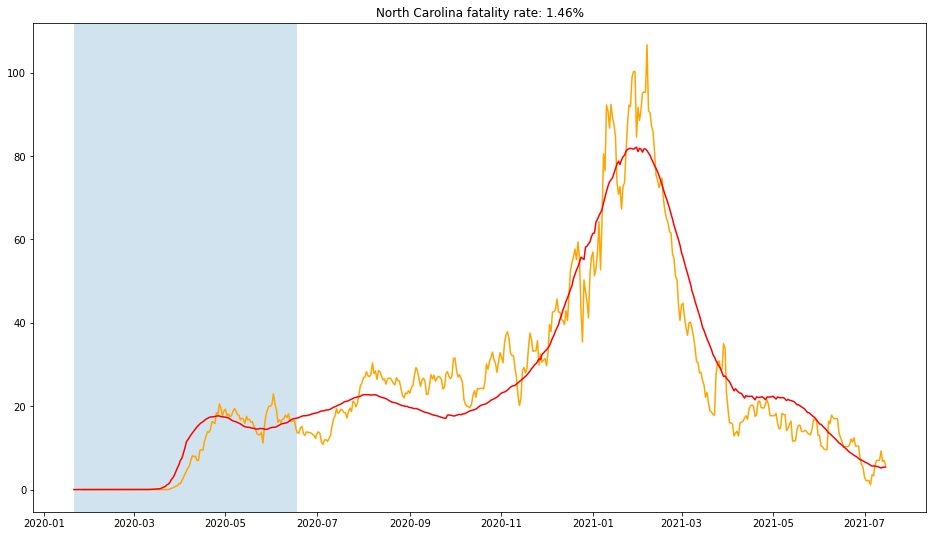

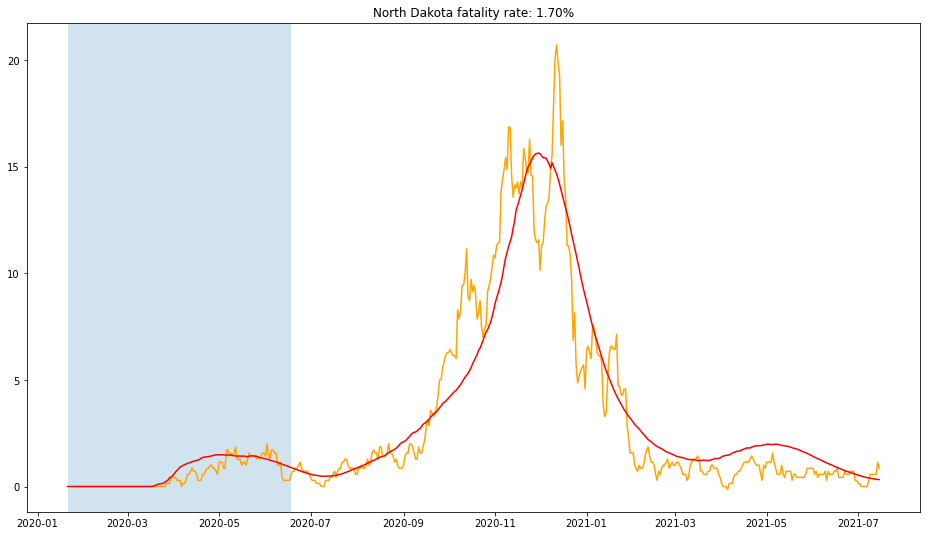

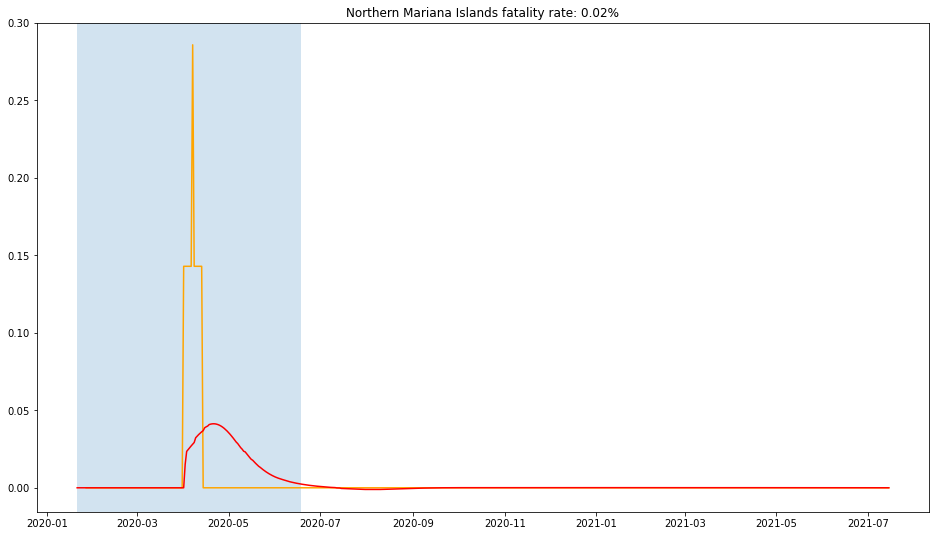

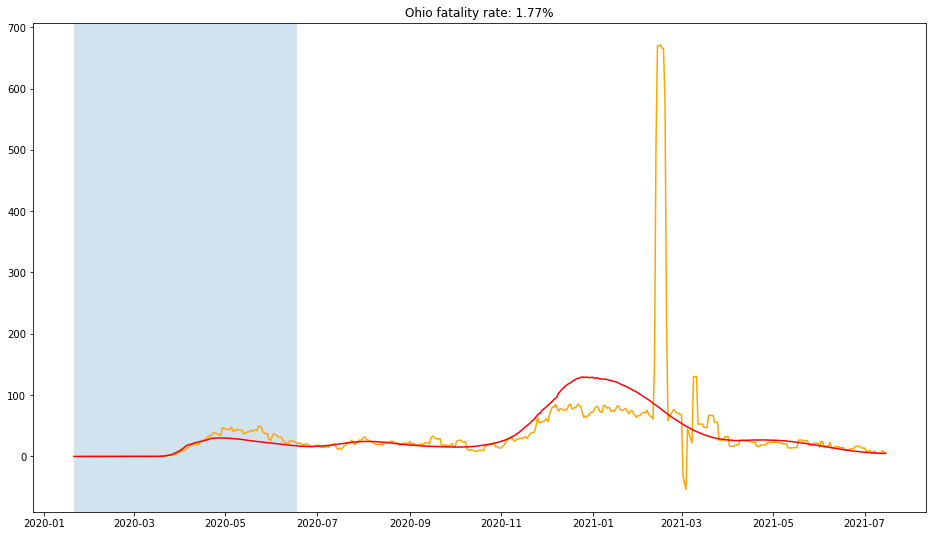

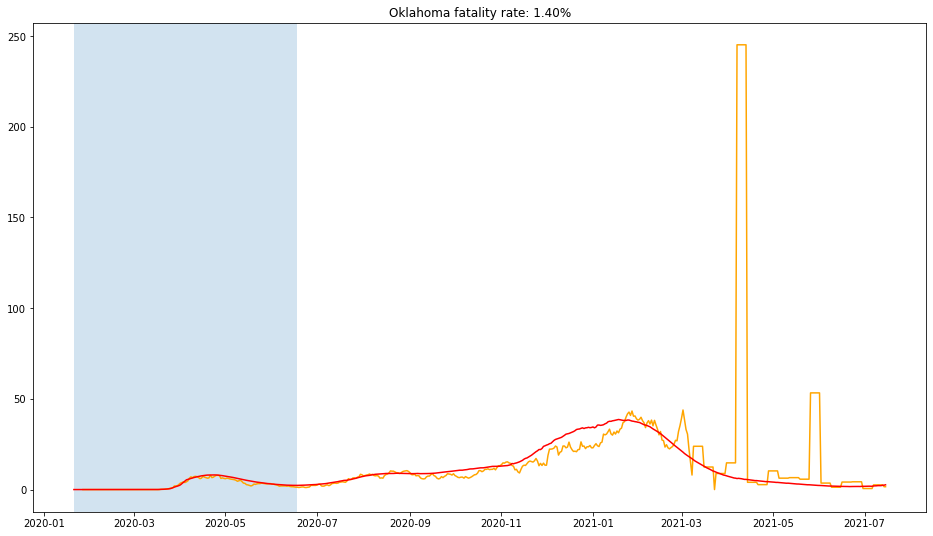

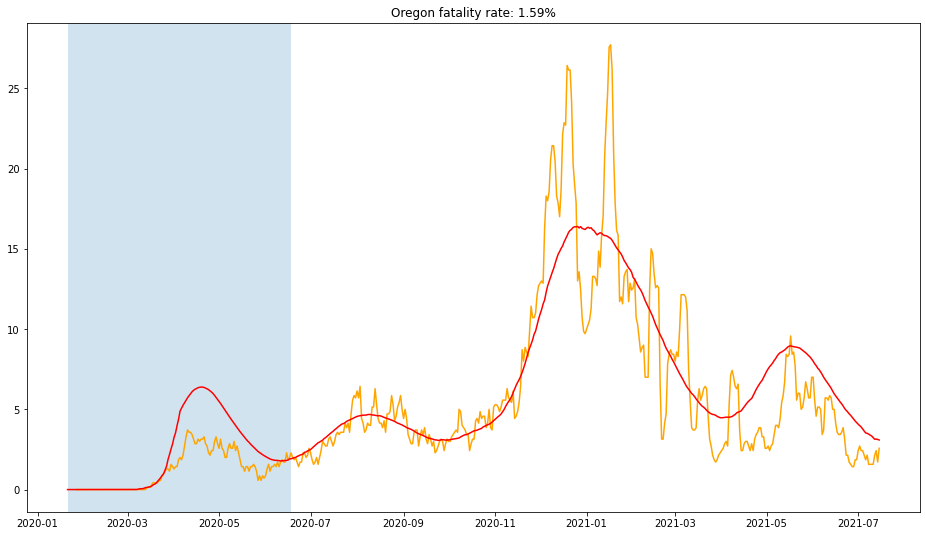

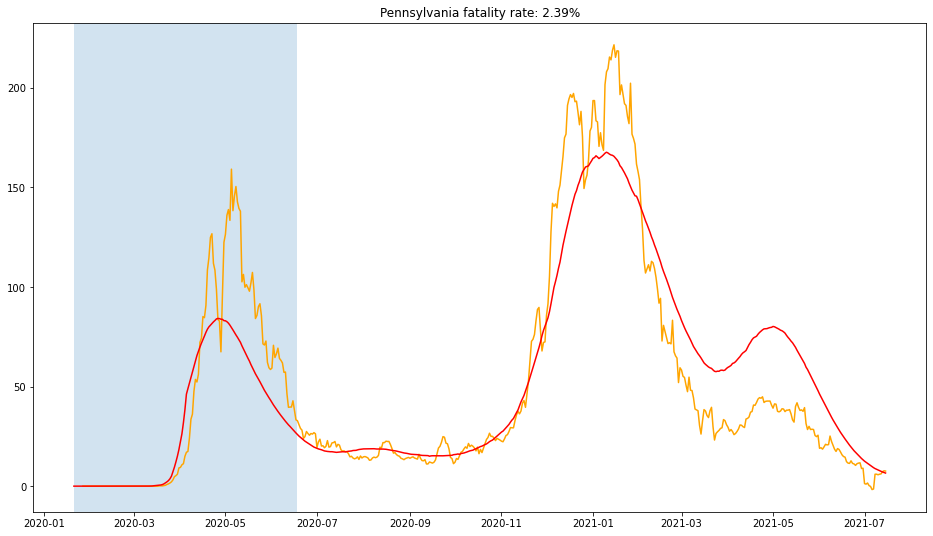

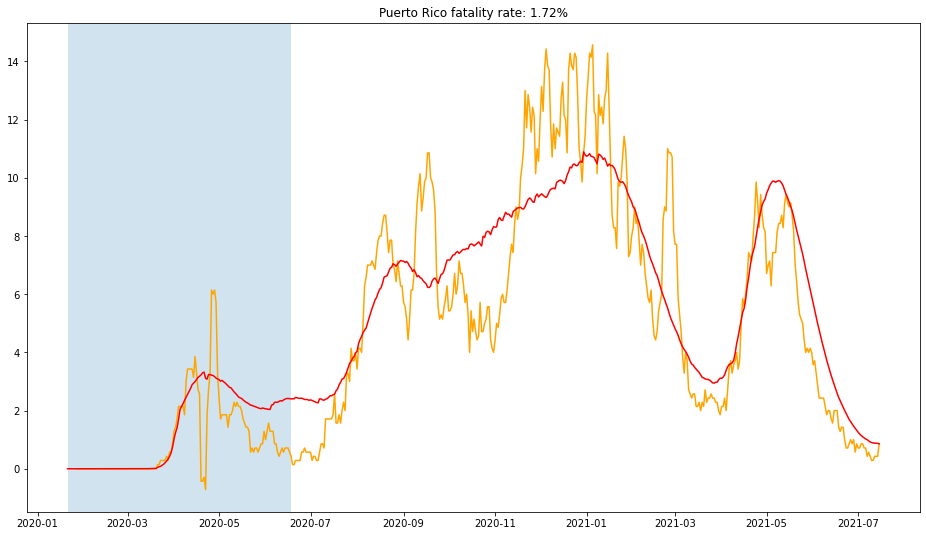

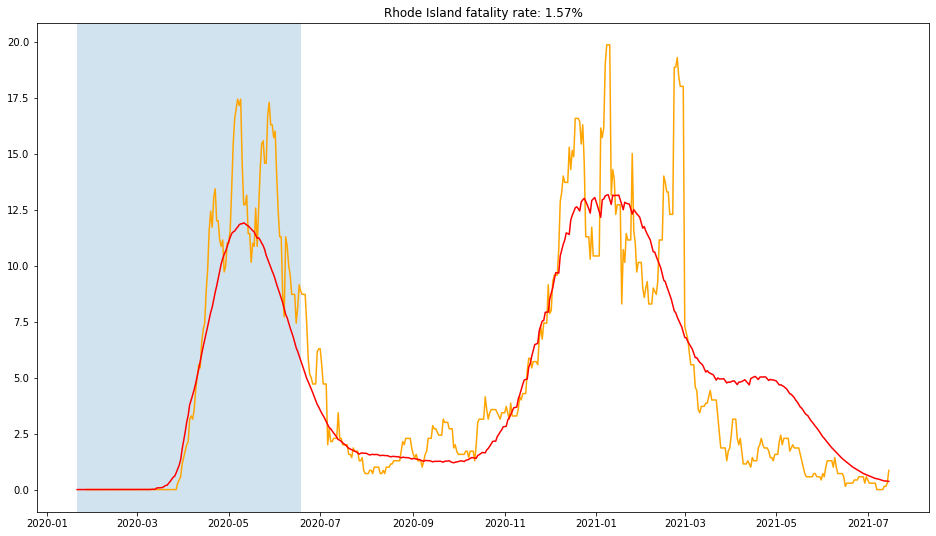

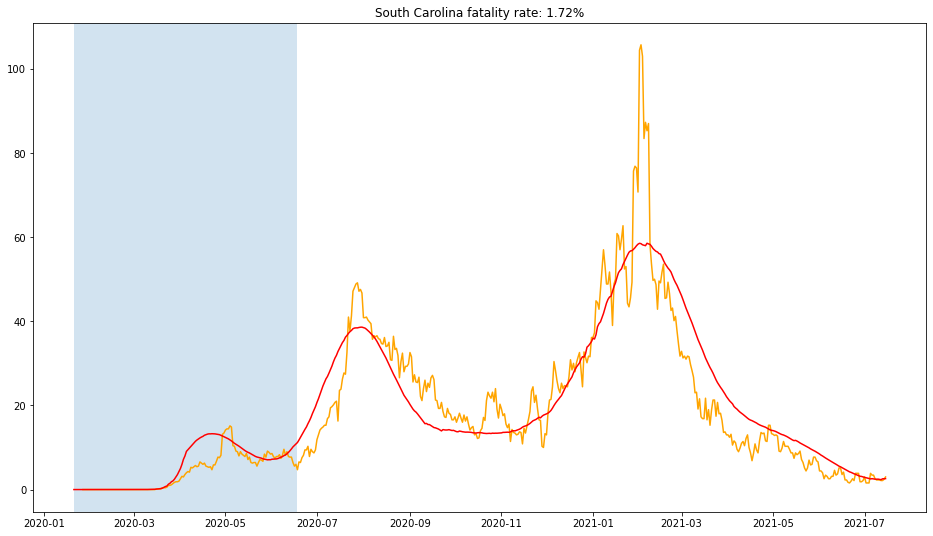

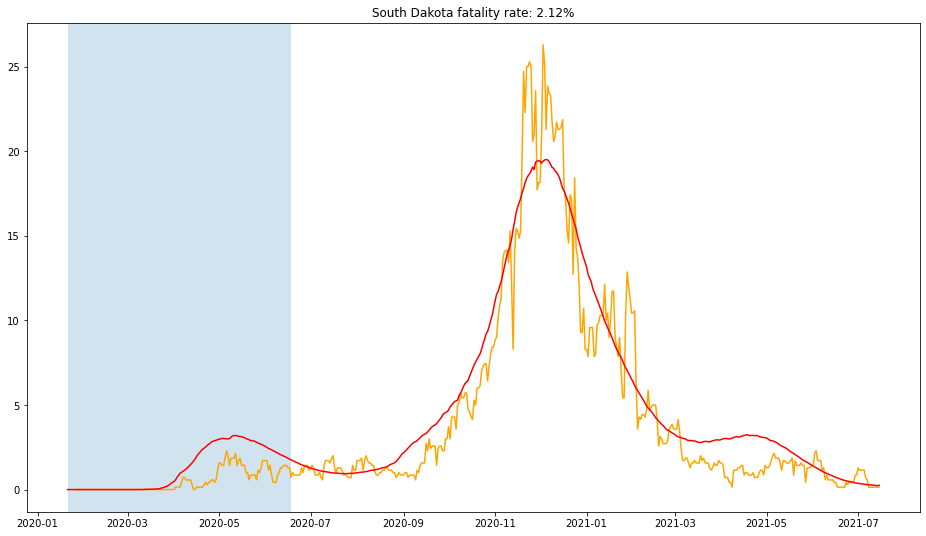

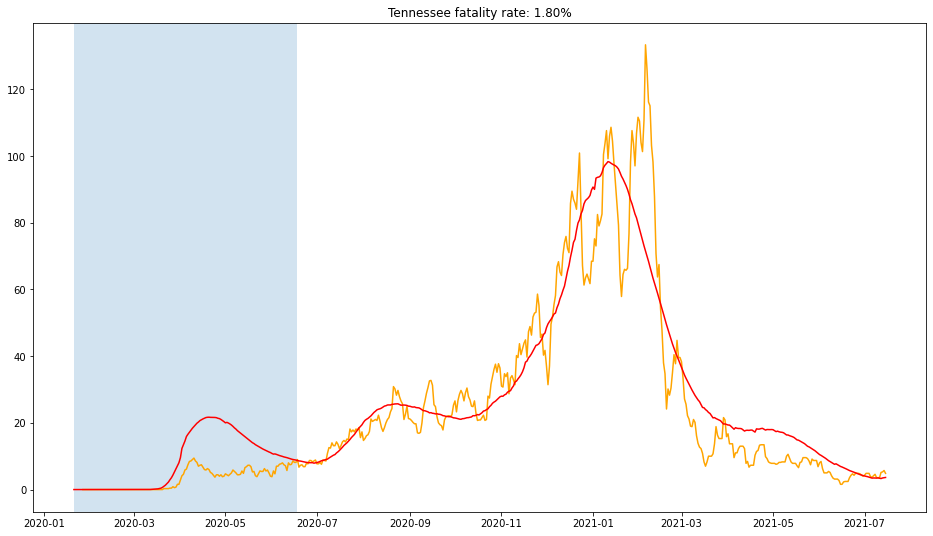

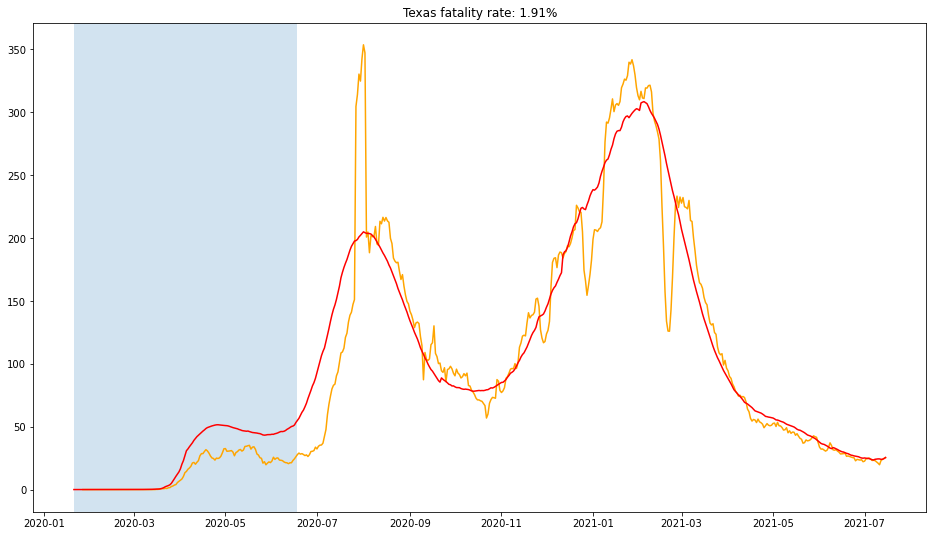

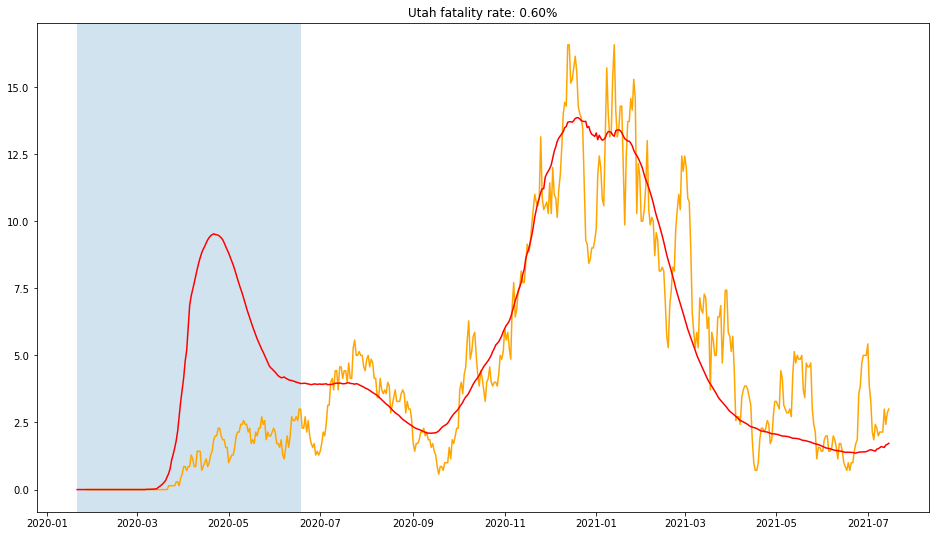

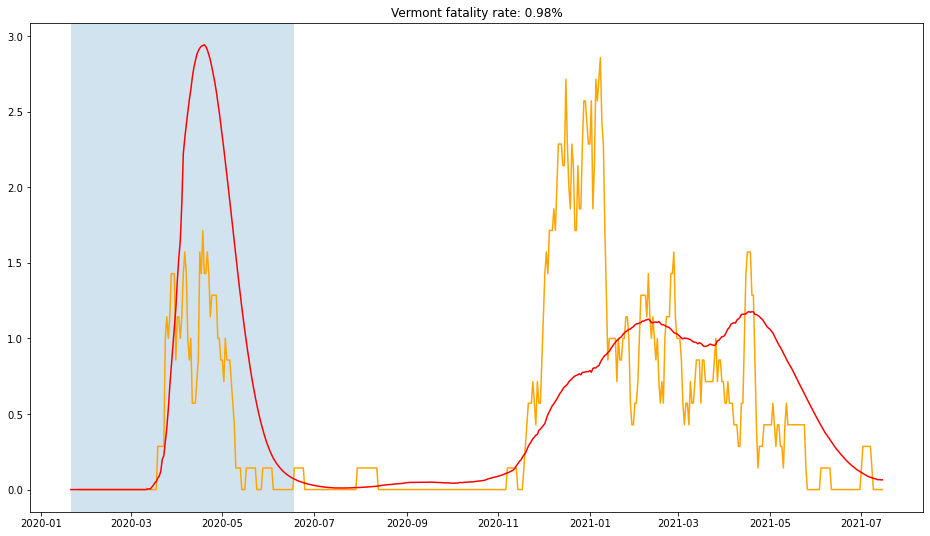

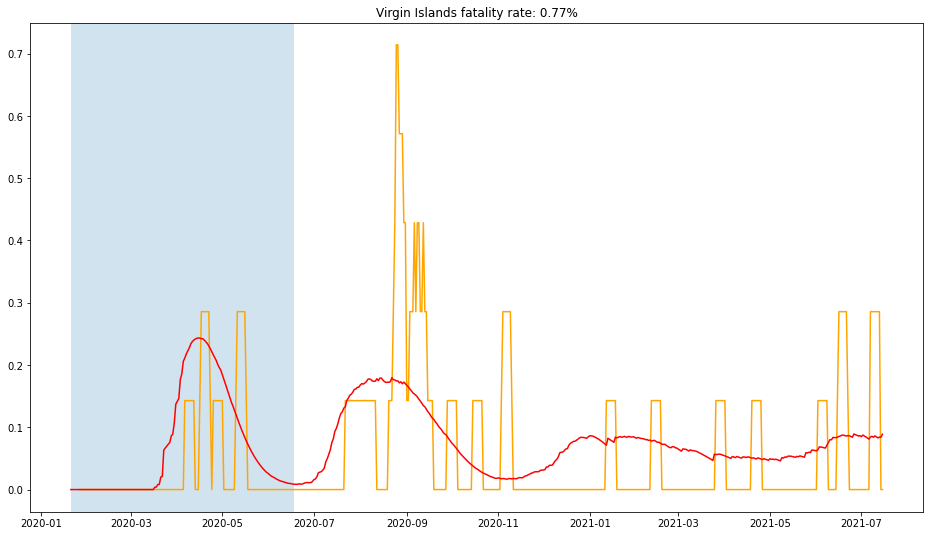

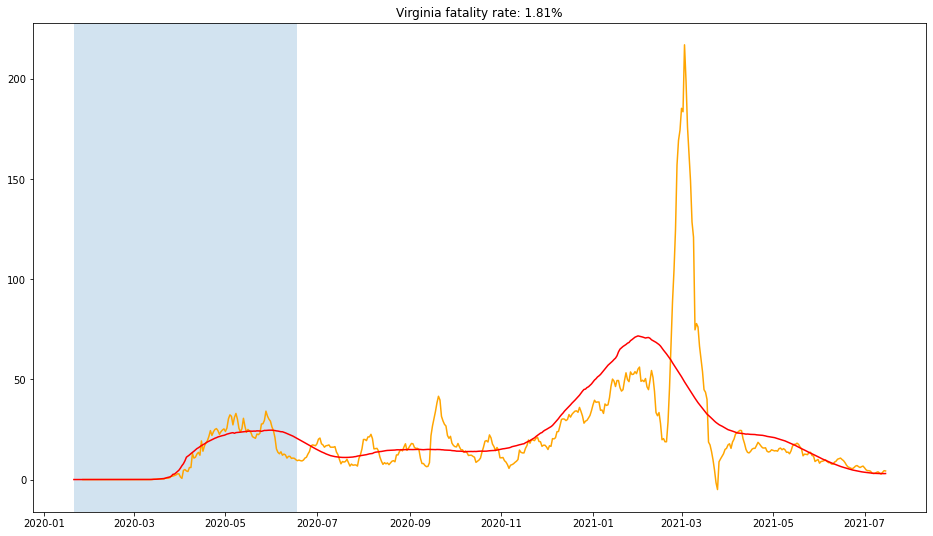

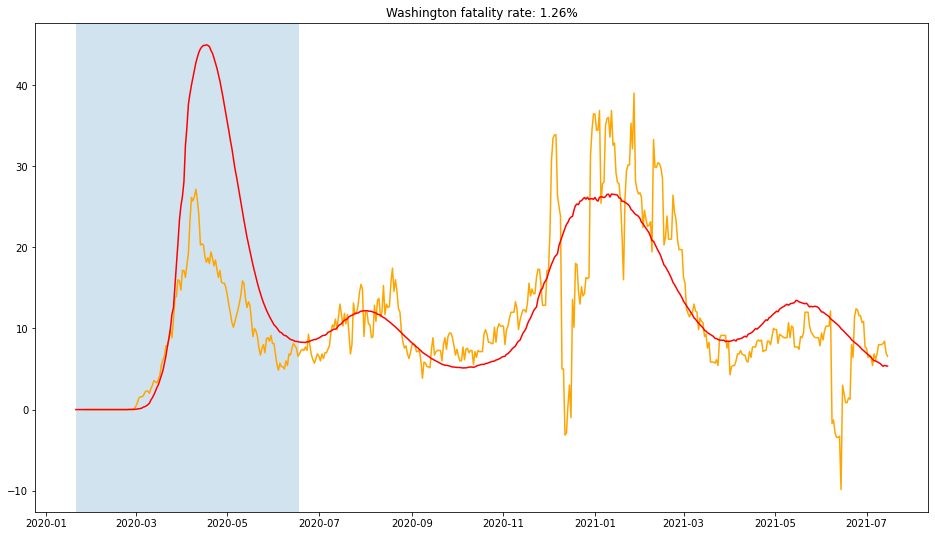

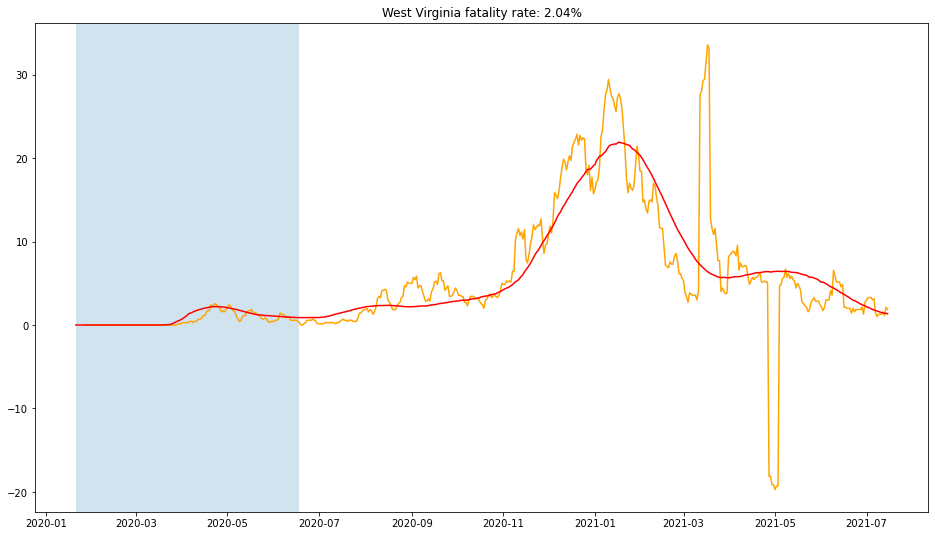

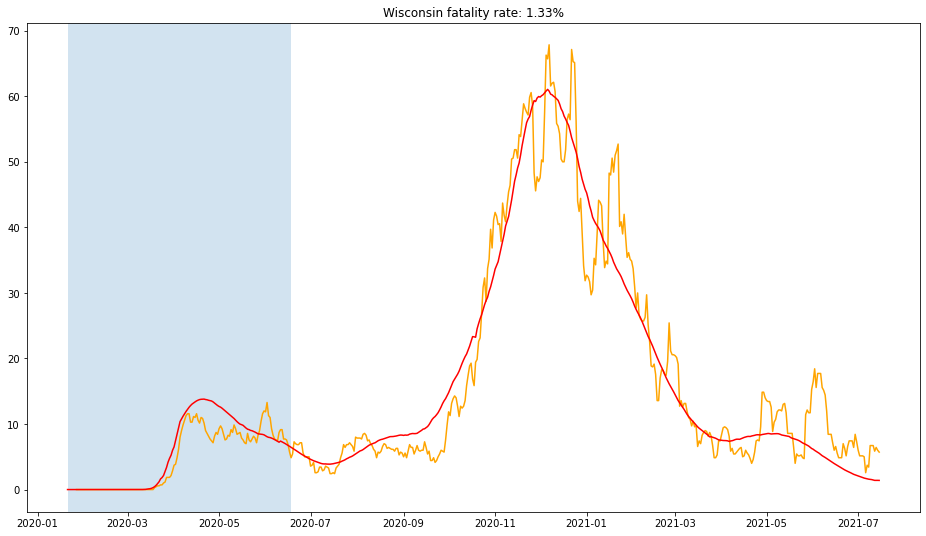

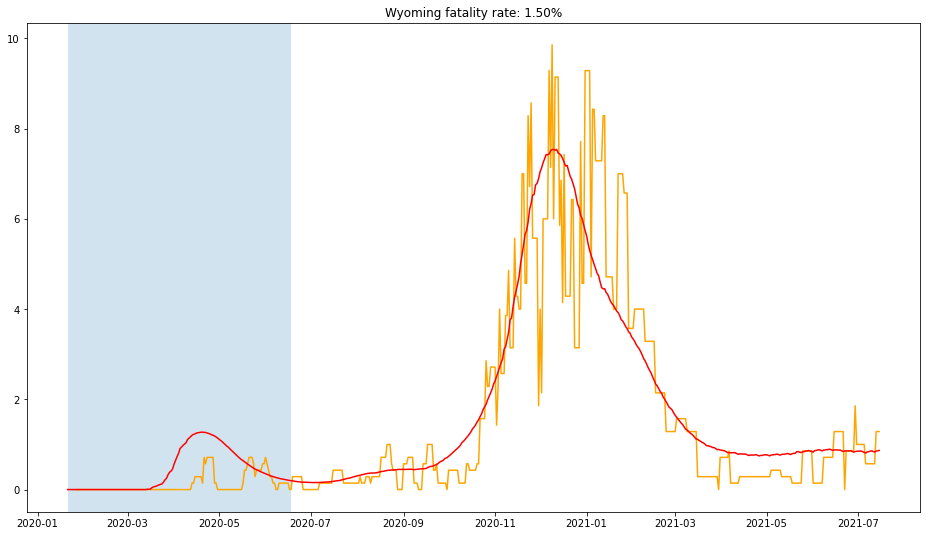

In [33]:
for state in all_states:
    state_fit(state, state_cases, state_deaths);